In [ ]:
import os
import torch.nn as nn
from sentencepiece import SentencePieceTrainer, SentencePieceProcessor
from sklearn.model_selection import train_test_split
import numpy as np

from typing import List, Union, Tuple, Iterable
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data import get_tokenizer
from torch.nn.utils.rnn import pad_sequence
import math
import warnings
warnings.filterwarnings("ignore")

import torch

берем вот это из прошлой домашки


часть кода и идей по реализации были взяты отсюда:

https://pytorch.org/tutorials/beginner/translation_transformer.html

но это, как я понял, not banable

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
UNK_ID = 0
PAD_ID = 1
BOS_ID = 2
EOS_ID = 3
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
EMB_SIZE = 512

SPECIAL_SYMBOLS = ('<unk>', '<pad>', '<bos>', '<eos>')

Немножко переделаем структуру прошлой домашки, вынесем в отдельный класс токенизацию, а за тем в классе для создания Dataset будет использовать класс токенизации

In [ ]:
class MyTokenizer:
    def __init__(self, train_data_file, val_data_file):
        self.train_mode = True

        train_texts = []
        with open(train_data_file, encoding="utf-8") as file:
            train_texts.extend(file.readlines())
        self.train_texts = train_texts

        val_texts = []
        with open(val_data_file, encoding="utf-8") as file:
            val_texts.extend(file.readlines())
        self.val_texts = val_texts

        self.tokenizer = get_tokenizer(None)

        self.vocab_transform = build_vocab_from_iterator(
            self._yield_tokens(),
            min_freq=1,
            specials=SPECIAL_SYMBOLS,
            special_first=True
        )
        self.vocab_transform.set_default_index(UNK_ID)

    def _yield_tokens(self) -> List[str]:
        for data_sample in self.train_texts:
            yield self.tokenizer(data_sample)

    def __getitem__(self, item: int) -> Tuple[torch.Tensor, torch.Tensor]:
        if self.train_mode:
            seq = self.train_texts[item]
        else:
            seq = self.val_texts[item]

        tokens = self.tokenizer(seq)
        token_ids = self.vocab_transform(tokens)

        token_ids = torch.cat((
            torch.tensor([BOS_ID], dtype=torch.int64),
            torch.tensor(token_ids, dtype=torch.int64),
            torch.tensor([EOS_ID], dtype=torch.int64)
        ))

        return token_ids

    def train(self):
        self.train_mode = True

    def eval(self):
        self.train_mode = False

In [ ]:
class TextDataset(Dataset):
    def __init__(
        self
    ):
        self.src_tokenizer = MyTokenizer(
            train_data_file='/kaggle/input/bhw2-translation/train.de-en.de',
            val_data_file='/kaggle/input/bhw2-translation/val.de-en.de',
        )
        self.tgt_tokenizer = MyTokenizer(
            train_data_file='/kaggle/input/bhw2-translation/train.de-en.en',
            val_data_file='/kaggle/input/bhw2-translation/val.de-en.en',
        )

    def __len__(self):
        if self.src_tokenizer.train_mode:
            return len(self.src_tokenizer.train_texts)
        return len(self.src_tokenizer.val_texts)

    def __getitem__(self, item: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.src_tokenizer[item], self.tgt_tokenizer[item]

    def text2ids(self, texts: Union[str, List[str]]) -> Union[List[int], List[List[int]]]:
        tokens = self.src_tokenizer.tokenizer(texts)
        token_ids = self.src_tokenizer.vocab_transform(tokens)
        token_ids = torch.cat((
            torch.tensor([BOS_ID], dtype=torch.int64),
            torch.tensor(token_ids, dtype=torch.int64),
            torch.tensor([EOS_ID], dtype=torch.int64)
        ))
        return torch.tensor(token_ids, dtype=torch.int64)

    def ids2text(self, ids: Union[torch.Tensor, List[int], List[List[int]]]) -> Union[str, List[str]]:
        return self.tgt_tokenizer.vocab_transform.lookup_tokens(ids)

    def train(self):
        self.src_tokenizer.train()
        self.tgt_tokenizer.train()

    def eval(self):
        self.src_tokenizer.eval()
        self.tgt_tokenizer.eval()

def collate_fn(batch):
    src_batch = [sample[0] for sample in batch]
    tgt_batch = [sample[1] for sample in batch]
    src_batch = pad_sequence(src_batch, padding_value=PAD_ID)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_ID)
    return src_batch, tgt_batch


теперь класс формирования датасета

зададим глобальные параметры константы:




In [ ]:
SRC_MODEL_TYPE = 'word'
TRGT_MODEL_TYPE = 'word'
SRC_LANG = 'de'
TRGT_LANG = 'en'

SRC_VOCAB_SIZE = 20000
TRGT_VOCAB_SIZE = 20000

SRC_MAX_LENGTH = 256
TRGT_MAX_LENGTH = 256

теперь разберемся с эмбеддингами и моделью.

код для трансформера был взят отсюда, говорю честно, так как почти 1 в 1 забрал:

https://pytorch.org/tutorials/beginner/translation_transformer.html

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout, maxlen=5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-1. * torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)

        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: torch.Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * torch.sqrt(torch.tensor(self.emb_size))


class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size, nhead, src_vocab_size, tgt_vocab_size, dim_feedforward, dropout):
        super().__init__()
        self.transformer = nn.Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src, trg, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src, src_mask):
        return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src)), src_mask)

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask)


def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_ID).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_ID).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


следующий код взят по той же ссылке

In [ ]:
def train_epoch(model, optimizer, dataset):
    model.train()
    dataset.train()

    losses = 0
    train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=2)

    for src, tgt in tqdm(train_dataloader, desc='training'):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]
        tgt_out = tgt[1:, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        loss = torch.nn.CrossEntropyLoss(ignore_index=PAD_ID)(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model: Seq2SeqTransformer, dataset: TextDataset):
    model.eval()
    dataset.eval()

    losses = 0
    val_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=2)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]
        tgt_out = tgt[1:, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        loss = torch.nn.CrossEntropyLoss(ignore_index=PAD_ID)(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))


def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_ID:
            break
    return ys


def translate(model: torch.nn.Module, src_sentence: str, text2ids, ids2text):
    model.eval()
    src = text2ids(src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_ID).flatten()
    return " ".join(ids2text(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")


код тоже оттуда, адаптировал под свои классы

файнали можем пообучать что-то

In [ ]:
dataset= TextDataset()

In [ ]:
dataset

отлично, теперь пообучаем

этот код тоже с того же сайта который указал в начале

In [ ]:
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 32
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6

DROPOUT = 0.1
DIM_FEEDFORWARD = 512
LR = 0.00007

In [ ]:
transformer = Seq2SeqTransformer(
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    emb_size=EMB_SIZE,
    nhead=NHEAD,
    src_vocab_size=len(dataset.src_tokenizer.vocab_transform),
    tgt_vocab_size=len(dataset.tgt_tokenizer.vocab_transform),
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT
).to(DEVICE)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

optimizer = torch.optim.Adam(transformer.parameters(), lr=LR, betas=(0.9, 0.98), eps=1e-9)
scheduler = None

In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 4.5 MB/s eta 0:00:00


In [ ]:
import sacrebleu

text2ids = dataset.text2ids
ids2text = dataset.ids2text

def save_model_wandb(model, epoch):
    model_filename = f"model_{epoch}.h5"
    torch.save(model, model_filename)
    wandb.save(model_filename)


def calculate_bleu(model, dataset):

    translations = [
        translate(model, sentence, text2ids, ids2text)
        for sentence in tqdm(dataset.src_tokenizer.val_texts, leave=False, desc="Calculating bleu")
    ]

    bleu = sacrebleu.corpus_bleu(translations, [dataset.tgt_tokenizer.val_texts])
    return bleu.score


def make_predictions(model, epoch):
    solution_filename = f"solution_{epoch}.txt"
    with open(f"test1.de-en.de", "r", encoding="utf-8") as f_input:
        with open(solution_filename, "w", encoding="utf-8") as f_output:
            for sentence in tqdm(
                f_input.readlines(), leave=False, desc="Making prediction for test"
            ):
                print(translate(model, sentence, text2ids, ids2text).strip(" "), file=f_output)

    wandb.save(solution_filename)

In [ ]:
import wandb

key = '0ac4efebc9f1b25b256f5c1e1eb34ecc07e40ffb'
wandb.login(key=key)



wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(
    project="de-en-translator", entity="ilyalobanov247", name="hyperparams_ED6L"
)



wandb: Currently logged in as: ilyalobanov247. Use `wandb login --relogin` to force relogin


In [ ]:
from timeit import default_timer as timer
from tqdm import tqdm

NUM_EPOCHS = 12
train_losses, val_losses = [], []
for epoch in tqdm(range(1, NUM_EPOCHS + 1), desc="Training Progress"):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, dataset)
    end_time = timer()
    val_loss = evaluate(transformer, dataset)

    if scheduler is not None:
        scheduler.step()


    train_losses.append(train_loss)
    val_losses.append(val_loss)

    bleu = calculate_bleu(transformer, dataset)
    save_model_wandb(transformer, epoch)

    make_predictions(transformer, epoch)

    epoch_time = end_time - start_time
    print(f"Epoch: {epoch}/{NUM_EPOCHS}, "
          f"Train loss: {train_loss:.3f}, "
          f"Val loss: {val_loss:.3f}, "
          f"Epoch time = {epoch_time:.3f}s")

    wandb.log(
        {
            "train_loss": round(train_loss, 3),
            "val_loss": round(val_loss, 3),
            "bleu": round(bleu, 3),
        }
    )

training:  22%|██▏       | 1368/6123 [03:20<10:44,  7.37it/s]

 сохраняем

In [ ]:
torch.save(transformer.state_dict(), 'transformer.model')
torch.save(optimizer.state_dict(), 'optimizer.opt')

считаем нашу метрику

In [ ]:
!pip install sacrebleu

In [ ]:
import sacrebleu

In [ ]:
token_transform = {}
vocab_transform = {}

In [ ]:
# !pip install -U spacy
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm

In [ ]:
# from torchtext.data.utils import get_tokenizer
# from torchtext.vocab import build_vocab_from_iterator

# token_transform[SRC_LANG] = get_tokenizer('spacy', language='de_core_news_sm')
# token_transform[TRGT_LANG] = get_tokenizer('spacy', language='en_core_web_sm')


# token_transform

In [ ]:
# def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
#     language_index = {SRC_LANG: 0, TRGT_LANG: 1}

#     for data_sample in data_iter:
#         yield token_transform[language](data_sample[language_index[language]])



In [ ]:
# dataset_train

In [ ]:
# special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

# for ln in [SRC_LANG, TRGT_LANG]:

#     vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(dataset_train, ln),
#                                                     min_freq=1,
#                                                     specials=special_symbols,
#                                                     special_first=True)


# for ln in [SRC_LANG, TGT_LANG]:
#     vocab_transform[ln].set_default_index(UNK_ID)

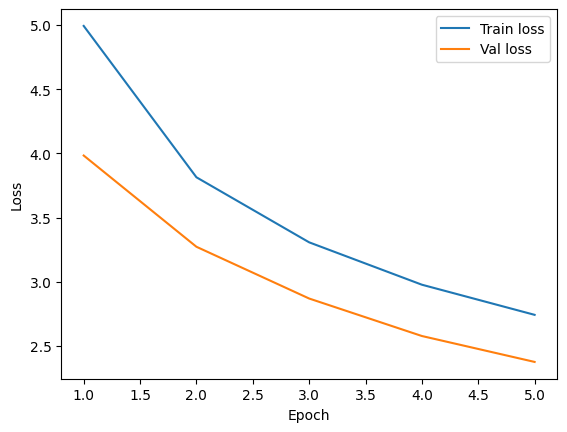

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, NUM_EPOCHS + 1)

plt.plot(epochs, train_losses, label='Train loss')
plt.plot(epochs, val_losses, label='Val loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [ ]:
torch.save(transformer.state_dict(), 'res.model')
torch.save(optimizer.state_dict(), 'res.opt')

Сначала делал по-другому, код ниже неактуален

In [ ]:

# val_src = dataset_val.src_tokenizer.texts
# val_tgt = dataset_val.trgt_tokenizer.texts

# text2ids = dataset.text2ids
# ids2text = dataset.ids2text
# # прогоняем отдельно каждое предложение
# translations = [translate(transformer, sentence, text2ids, ids2text) for sentence in val_src]

# bleu = sacrebleu.corpus_bleu(translations, [val_tgt])
# print(bleu.score)

теперь применим функцию перевода к нашему файлу с ответами

In [ ]:
text2ids = dataset.text2ids
ids2text = dataset.ids2text

with open('/kaggle/input/bhw2-translation/test1.de-en.de', 'r', encoding="utf-8") as f_input:
    with open('solution.txt', 'w', encoding="utf-8") as f_output:
        sentences = f_input.readlines()
        for sentence in tqdm(sentences, desc="Translating sentences"):
            print(translate(transformer, sentence, text2ids, ids2text).strip(" "), file=f_output)

Translating sentences: 100%|██████████| 2998/2998 [04:32<00:00, 10.98it/s]
